In [253]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from keras.preprocessing.sequence import pad_sequences


from collections import Counter
import nltk
import seaborn as sns
import string
from nltk.corpus import stopwords
# import re
# from autocorrect import spell
import regex as re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import eval
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,MaxPooling1D

In [254]:
df = pd.read_csv('../input/7282_1.csv')
df.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [255]:
data=df[['reviews.text','reviews.rating']]
data.head()

,reviews.text,reviews.rating
0,Pleasant 10 min walk along the sea front to th...,4.0
1,Really lovely hotel. Stayed on the very top fl...,5.0
2,Ett mycket bra hotell. Det som drog ner betyge...,5.0
3,We stayed here for four nights in October. The...,5.0
4,We stayed here for four nights in October. The...,5.0


In [256]:
review=pd.DataFrame(data.groupby('reviews.rating').size().sort_values(ascending=False).rename('No of Users').reset_index())
review.head()

,reviews.rating,No of Users
0,5.0,12671
1,4.0,9755
2,3.0,5708
3,1.0,3068
4,2.0,2979


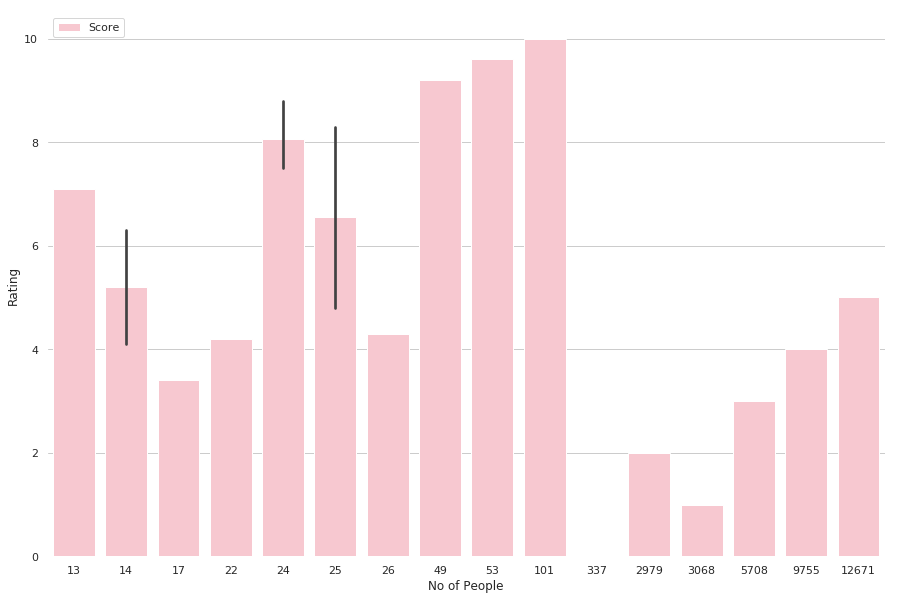

In [257]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))
sns.set_color_codes("pastel") 
sns.barplot(y="reviews.rating", x="No of Users", data=review.iloc[:20, :10],label="Score", color="pink")

ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set(xlabel="No of People",ylabel="Rating") 
sns.despine(left=True, bottom=True)
plt.show()

In [258]:
mpermanent=data.dropna()
mpermanent[mpermanent['reviews.rating'] != 3]
mpermanent['positively Rated'] = np.where(mpermanent['reviews.rating'] > 2, 1, 0)
mpermanent.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,reviews.text,reviews.rating,positively Rated
0,Pleasant 10 min walk along the sea front to th...,4.0,1
1,Really lovely hotel. Stayed on the very top fl...,5.0,1
2,Ett mycket bra hotell. Det som drog ner betyge...,5.0,1
3,We stayed here for four nights in October. The...,5.0,1
4,We stayed here for four nights in October. The...,5.0,1


In [259]:
reviews=mpermanent['reviews.text']

In [260]:
reviews[1]

"Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the included breakfast was great! Great location and great value for money. Didn't want to leave!"

In [261]:
stop=set(stopwords.words('english'))

In [262]:
def clean_document(doco):
    punctuation = string.punctuation
    punc_replace = ''.join([' ' for s in punctuation])
    doco_link_clean = re.sub(r'http\S+', '', doco)
    doco_clean_and = re.sub(r'&\S+', '', doco_link_clean)
    doco_clean_at = re.sub(r'@\S+', '', doco_clean_and)
    doco_clean = doco_clean_at.replace('-', ' ')
    doco_alphas = re.sub(r'\W +', ' ', doco_clean)
    trans_table = str.maketrans(punctuation, punc_replace)
    doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')])
    doco_clean = doco_clean.split(' ')
    p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
    doco_clean = [word.lower() for word in doco_clean if len(word) > 2]
    doco_clean = ([i for i in doco_clean if i not in stop])
#     doco_clean = [spell(word) for word in doco_clean]
#     p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
#     doco_clean = ([spell(k) for k in doco_clean])
    return doco_clean

In [263]:
review_cleans = [clean_document(doc) for doc in reviews];
sentences = [' '.join(r) for r in review_cleans ]

In [264]:
mpermanent['clean.text']=sentences
mpermanent.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,reviews.text,reviews.rating,positively Rated,clean.text
0,Pleasant 10 min walk along the sea front to th...,4.0,1,pleasant min walk along sea front water bus re...
1,Really lovely hotel. Stayed on the very top fl...,5.0,1,really lovely hotel stayed top floor surprised...
2,Ett mycket bra hotell. Det som drog ner betyge...,5.0,1,ett mycket bra hotell det som drog ner betyget...
3,We stayed here for four nights in October. The...,5.0,1,stayed four nights october hotel staff welcomi...
4,We stayed here for four nights in October. The...,5.0,1,stayed four nights october hotel staff welcomi...


In [265]:
mpermanent.isnull().sum()

reviews.text        0
reviews.rating      0
positively Rated    0
clean.text          0
dtype: int64

In [266]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mpermanent['clean.text'], mpermanent['positively Rated'], random_state = 101)

In [267]:
print('X_train first entry: \n\n', X_train[1])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 really lovely hotel stayed top floor surprised jacuzzi bath know getting staff friendly helpful included breakfast great great location great value money want leave


X_train shape:  (26271,)


In [268]:
import string
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [269]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(analyzer=text_process).fit(X_train)

In [270]:
vect.get_feature_names()[::3000]

['00am',
 'bolt',
 'danisha',
 'firework',
 'initially',
 'molding',
 'prettier',
 'shoppers',
 'travail']

In [271]:
len(vect.get_feature_names())

26595

In [272]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<26271x26595 sparse matrix of type '<class 'numpy.int64'>'
	with 563816 stored elements in Compressed Sparse Row format>

In [273]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [274]:
from sklearn.metrics import roc_auc_score

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.7570842108024094


In [275]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['roaches' 'dump' 'refund' 'sale' 'waste' 'lowest' 'stolen' 'cockroach'
 'pictures' 'feather']

Largest Coefs: 
['bien' 'enjoyed' 'loved' 'perfect' 'french' 'surprised' 'amazing'
 'besides' 'tvs' 'complaint']



In [276]:
#Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df = 5).fit(X_train)
len(vect.get_feature_names())

7009

In [277]:
X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.7412534700394195


In [278]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest Tfidf: 
['gifts' 'vide' 'gibt' 'gironde' 'estuaire' 'garonne' 'dlicieux' 'ajoute'
 'paisible' 'heures']

Largest Tfidf: 
['una' 'average' 'vacation' 'tima' 'poco' 'pleased' 'pleasant' 'awful'
 'comfortable' 'awesome']



In [279]:
sorted_coef_index = model.coef_[0].argsort()

print('Smallest coef: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest coef: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest coef: 
['dirty' 'worst' 'roaches' 'never' 'poor' 'filthy' 'refund' 'disgusting'
 'pictures' 'run']

Largest coef: 
['great' 'nice' 'comfortable' 'enjoyed' 'clean' 'excellent' 'loved'
 'perfect' 'wonderful' 'beautiful']



In [280]:
# These reviews are treated the same by our current model

print(model.predict(vect.transform(['Not an issue, phone is working', 
                                   'an issue, phone is not working'])))

[1 1]


In [281]:
# n-grams
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df = 5, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
len(vect.get_feature_names())

21848

In [282]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.7659235148738941


In [283]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:10]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-11:-1]))

Smallest Coef: 
['roaches' 'dump' 'sale' 'good thing' 'refund' 'dirty' 'nightmare'
 'late evening' 'sucio' 'cockroach']

Largest Coef: 
['bien' 'loved' 'surprised' 'enjoyed' 'perfect' 'amazing' 'complaint'
 'awesome' 'quick' 'outside door']



In [284]:
print(model.predict(vect.transform(['run down'])))

[1]


In [285]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_vectorized, y_train)
predictions = nb.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8221612518116969


In [286]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = nb.coef_[0].argsort()

print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:10]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-11:-1]))

Smallest Coef: 
['smell dirty' 'around bathroom' 'muy sucio' 'dirty roaches' 'also dirty'
 'smelly dirty' 'party night' 'place horrible' 'siquiera' 'slept car']

Largest Coef: 
['hotel' 'room' 'great' 'staff' 'stay' 'clean' 'nice' 'breakfast' 'good'
 'friendly']



In [287]:
print(nb.predict(vect.transform(['room was dirty'])))

[0]
